In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


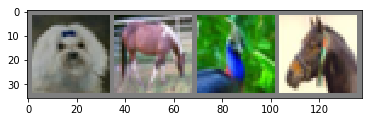

  dog horse  bird horse


In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
from model import Net
import torch.nn as nn

net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.900
[1,  6000] loss: 1.691
[1,  8000] loss: 1.582
[1, 10000] loss: 1.531
[1, 12000] loss: 1.430
[2,  2000] loss: 1.411
[2,  4000] loss: 1.350
[2,  6000] loss: 1.356
[2,  8000] loss: 1.275
[2, 10000] loss: 1.268
[2, 12000] loss: 1.260
Finished Training


In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [8]:
import blazee
import logging
import os
logging.basicConfig(level=logging.INFO)
%load_ext autoreload
%autoreload 2

# Deploy the model on Blazee
api_key = os.environ['BLAZEE_API_KEY']
bz = blazee.Blazee(api_key)

In [9]:
bz_model = bz.deploy_model(net, model_name='PyTorch', include_files=['model.py'])

Using TensorFlow backend.
INFO:root:Adding file deps/model.py
INFO:root:Uploading model version to Blazee  (258.439453 KB)...
INFO:root:Deploying new model version: v1...
INFO:root:Successfully deployed model version e4de4fe5-91f4-4ba1-8c67-9b2a768ca18b


In [16]:
# Extracting a few images
dataiter = iter(testloader)
images, labels = dataiter.next()

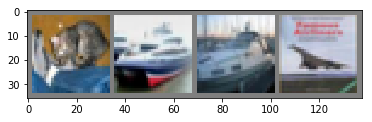

GroundTruth:    cat  ship  ship plane


In [17]:
# Ground Truth
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
# Local Predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)
for i, p in enumerate(predicted):
    print(classes[p])

cat
ship
car
plane


In [20]:
# Blazee Predictions
outputs = bz_model.predict_batch(images.tolist())
for p in outputs:
    print(classes[p.prediction])

cat
ship
car
plane
